In [1]:
#Basic settings and package import

!pip install pulp
import datetime
import pulp
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters


plt.style.use('seaborn-bright')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import price data and convert to better format

data21 = pd.read_csv('2021.csv')
data21 = data21['MTU (CET/CEST),"Day-ahead Price [EUR/MWh]","Currency","BZN|DE-LU"'].str.split(',', expand=True)
data21[['start_date','end_date']] = data21[0].str.split('-', expand=True)
del data21[0]
del data21['end_date']
data21.rename(columns = {1:'price', 2:'currency'}, inplace = True)
data21['price']=data21['price'].str.replace('"', '')
data21['currency']=data21['currency'].str.replace('"', '')
data21['price'] = data21['price'].replace(r'^\s*$', np.nan, regex=True)
data21['price'] = data21['price'].astype(float)
data21['start_date'] = pd.to_datetime(data21['start_date'])
data21['start_time']=data21['start_date'].dt.strftime("%H:%M")
data21['start_date']=data21['start_date'].dt.date
print(data21)

      price currency  start_date start_time
0     50.87      EUR  2021-01-01      00:00
1     48.19      EUR  2021-01-01      01:00
2     44.68      EUR  2021-01-01      02:00
3     42.92      EUR  2021-01-01      03:00
4     40.39      EUR  2021-01-01      04:00
...     ...      ...         ...        ...
8756  32.49      EUR  2021-12-31      19:00
8757   0.18      EUR  2021-12-31      20:00
8758   0.08      EUR  2021-12-31      21:00
8759   5.10      EUR  2021-12-31      22:00
8760   6.32      EUR  2021-12-31      23:00

[8761 rows x 4 columns]


In [3]:
#Average price in kWh

mean_price = data21['price'].mean()
mean_price / 1000

0.09684991780821911

In [4]:
#Calculate average price per hour over the year

mean_price21 = pd.DataFrame(data21.groupby('start_time')['price'].mean())
print(mean_price21)

                 price
start_time            
00:00        81.629342
01:00        76.480110
02:00        73.568904
03:00        71.295288
04:00        72.421945
05:00        78.102795
06:00        95.316575
07:00       112.382712
08:00       118.653644
09:00       112.350712
10:00       104.570493
11:00       100.407452
12:00        95.088603
13:00        89.024575
14:00        87.591397
15:00        91.399452
16:00        98.663096
17:00       114.470630
18:00       123.198247
19:00       125.255397
20:00       115.938932
21:00       103.792959
22:00        97.942000
23:00        84.852767


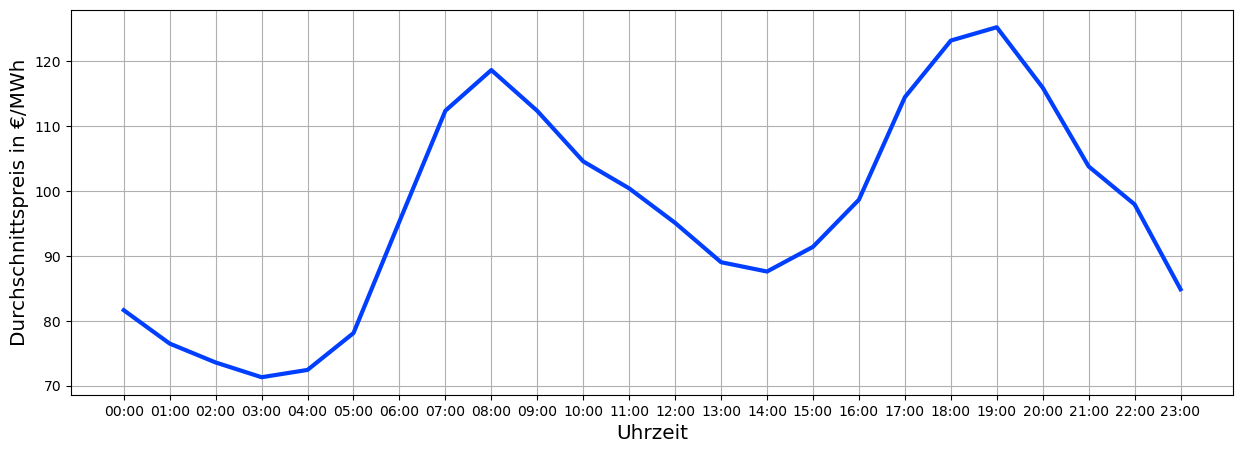

In [5]:
#Plot mean prices (see comments in V2G task file)
mean_price21_indexed = mean_price21.reset_index()
mean_price21_indexed['start_time'] = mean_price21_indexed['start_time'].astype(str)

plt.figure(figsize=(15,5))
plt.xlabel("Uhrzeit", size="x-large")
plt.ylabel("Durchschnittspreis in €/MWh", size="x-large")
plt.grid(True)
#plt.title("Durchschnittliche Strompreise pro Stunde in 2021")
plt.plot(mean_price21_indexed['start_time'], mean_price21_indexed['price'], linewidth=3)

In [6]:
#Analyse mean prices per month for further analysis (see comments in V2G task file)
data21_monthly = data21.copy(deep=True)

#Step 1: Convert the start_date column to datetime format
data21_monthly['start_date'] = pd.to_datetime(data21_monthly['start_date'])

#Step 2: Keep only teh
data21_monthly['start_date'] = data21_monthly['start_date'].dt.to_period('M')

data21_monthly_meaned = data21_monthly.groupby(by='start_date')['price'].mean()
data21_monthly_meaned_indexed = data21_monthly_meaned.reset_index()
print(data21_monthly_meaned_indexed)

   start_date       price
0     2021-01   60.252836
1     2021-02   65.364613
2     2021-03   60.029731
3     2021-04   73.343917
4     2021-05   65.839919
5     2021-06   83.484264
6     2021-07   84.547836
7     2021-08   90.480511
8     2021-09  120.377806
9     2021-10  119.111933
10    2021-11  157.676125
11    2021-12  180.094839


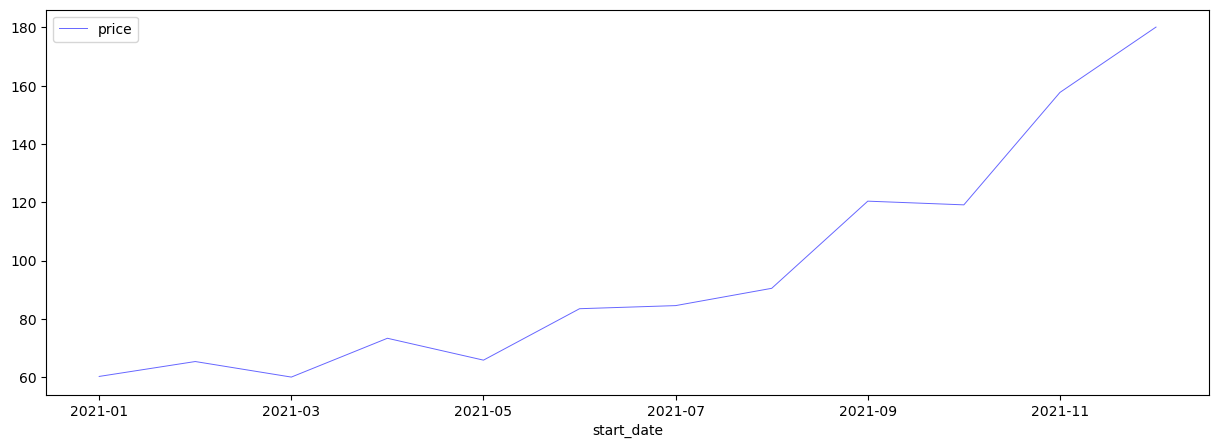

In [7]:
#Plot average monthly prices (incomplete: improve graph quality)

data21_monthly_meaned_indexed['start_date'] = data21_monthly_meaned_indexed['start_date'].astype(str)
ax = data21_monthly_meaned_indexed.plot(x ="start_date" , y="price" , kind="line" ,figsize=[15, 5], linewidth=0.7, alpha=0.6, color="#0000FF")
plt.show()

## Profit maximization

### Prepare data

In [8]:
# Constants to filter price data
morning = 7     # time at which driver leaves the house (note: driver leaves house at the end of this hour, e.g. 7 means he is leaving at 08:00)
evening = 18    # time at which driver returns home

# Filter price data frame by hours in which charging / discharging is possible

def select_timestamp(time):
    hours = int(time.split(':')[0])
    return True if hours <= morning or hours >= evening else False 

data21['selection'] = data21['start_time'].apply(select_timestamp)
data21 = data21[data21['selection']]
data21

,price,currency,start_date,start_time,selection
0,50.87,EUR,2021-01-01,00:00,True
1,48.19,EUR,2021-01-01,01:00,True
2,44.68,EUR,2021-01-01,02:00,True
3,42.92,EUR,2021-01-01,03:00,True
4,40.39,EUR,2021-01-01,04:00,True
...,...,...,...,...,...
8756,32.49,EUR,2021-12-31,19:00,True
8757,0.18,EUR,2021-12-31,20:00,True
8758,0.08,EUR,2021-12-31,21:00,True
8759,5.10,EUR,2021-12-31,22:00,True


In [9]:
def rename_timestamp(time):
    hours = int(time.split(':')[0])
    if hours >= 18:
        hours -= 10
    return f"{hours}:00"

data21['start_time_new'] = data21['start_time'].apply(rename_timestamp)
data21

,price,currency,start_date,start_time,selection,start_time_new
0,50.87,EUR,2021-01-01,00:00,True,0:00
1,48.19,EUR,2021-01-01,01:00,True,1:00
2,44.68,EUR,2021-01-01,02:00,True,2:00
3,42.92,EUR,2021-01-01,03:00,True,3:00
4,40.39,EUR,2021-01-01,04:00,True,4:00
...,...,...,...,...,...,...
8756,32.49,EUR,2021-12-31,19:00,True,9:00
8757,0.18,EUR,2021-12-31,20:00,True,10:00
8758,0.08,EUR,2021-12-31,21:00,True,11:00
8759,5.10,EUR,2021-12-31,22:00,True,12:00


In [10]:
# Create time stamp for tracking later

data21['Time Stamp'] = data21['start_date'].astype(str) + " " + data21['start_time_new'].astype(str)
data21 = data21.set_index(['Time Stamp'])
data21.head(30)

,price,currency,start_date,start_time,selection,start_time_new
Time Stamp,,,,,,
2021-01-01 0:00,50.87,EUR,2021-01-01,00:00,True,0:00
2021-01-01 1:00,48.19,EUR,2021-01-01,01:00,True,1:00
2021-01-01 2:00,44.68,EUR,2021-01-01,02:00,True,2:00
2021-01-01 3:00,42.92,EUR,2021-01-01,03:00,True,3:00
2021-01-01 4:00,40.39,EUR,2021-01-01,04:00,True,4:00
2021-01-01 5:00,40.20,EUR,2021-01-01,05:00,True,5:00
2021-01-01 6:00,39.63,EUR,2021-01-01,06:00,True,6:00
2021-01-01 7:00,40.09,EUR,2021-01-01,07:00,True,7:00
2021-01-01 8:00,60.61,EUR,2021-01-01,18:00,True,8:00


In [11]:
data21.index = pd.to_datetime(data21.index, format='%Y-%m-%d %H:%M')
data21

,price,currency,start_date,start_time,selection,start_time_new
Time Stamp,,,,,,
2021-01-01 00:00:00,50.87,EUR,2021-01-01,00:00,True,0:00
2021-01-01 01:00:00,48.19,EUR,2021-01-01,01:00,True,1:00
2021-01-01 02:00:00,44.68,EUR,2021-01-01,02:00,True,2:00
2021-01-01 03:00:00,42.92,EUR,2021-01-01,03:00,True,3:00
2021-01-01 04:00:00,40.39,EUR,2021-01-01,04:00,True,4:00
...,...,...,...,...,...,...
2021-12-31 09:00:00,32.49,EUR,2021-12-31,19:00,True,9:00
2021-12-31 10:00:00,0.18,EUR,2021-12-31,20:00,True,10:00
2021-12-31 11:00:00,0.08,EUR,2021-12-31,21:00,True,11:00


In [12]:
data21 = data21.loc[:,['price']]
data21 = data21[~data21.index.duplicated(keep='first')]
data21['price'].fillna((data21['price'].mean()), inplace=True)
data21

,price
Time Stamp,
2021-01-01 00:00:00,50.87
2021-01-01 01:00:00,48.19
2021-01-01 02:00:00,44.68
2021-01-01 03:00:00,42.92
2021-01-01 04:00:00,40.39
...,...
2021-12-31 09:00:00,32.49
2021-12-31 10:00:00,0.18
2021-12-31 11:00:00,0.08


### Build optimization model

In [13]:
class Battery():
    def __init__(self,
                 time_horizon,
                 charge_capacity):
        #Set up decision variables for optimization.
        #These are the hourly charge and discharge flows for
        #the optimization horizon, with their limitations.
        self.time_horizon = time_horizon
    
        self.charge = \
        pulp.LpVariable.dicts(
            "charging_power",
            ('c_t_' + str(i) for i in range(0,self.time_horizon)),
            lowBound=0, upBound=charge_capacity,
            cat='Continuous')

        self.discharge = \
        pulp.LpVariable.dicts(
            "discharging_power",
            ('d_t_' + str(i) for i in range(0,self.time_horizon)),
            lowBound=0, upBound=charge_capacity,
            cat='Continuous')

    def set_objective(self, prices, efficiency):
        #Create a model and objective function.
        #This uses price data, which must have one price
        #for each point in the time horizon.
        try:
            assert len(prices) == self.time_horizon
        except:
            print('Error: need one price for each hour in time horizon')
        
        #Instantiate linear programming model to maximize the objective
        self.model = pulp.LpProblem("Energy arbitrage", pulp.LpMaximize)
    
        #Objective is profit
        #This formula gives the daily profit from charging/discharging
        #activities. Charging is a cost, discharging is a revenue
        
        #Edit for efficiency
        
        self.model += \
        pulp.LpAffineExpression(
            [(self.charge['c_t_' + str(i)],
              -1*prices[i]) for i in range(0,self.time_horizon)]) +\
        pulp.LpAffineExpression(
            [(self.discharge['d_t_' + str(i)],
              prices[i]/efficiency) for i in range(0,self.time_horizon)])
        
    def add_storage_constraints(self,
                                driving,
                                battery_min,
                                battery_max,
                                battery_morning,
                                initial_level,
                                fixedprice,
                                prices
                                ):
        #Storage level constraint 1
        #This says the battery cannot have less than zero energy, at
        #any hour in the horizon
     
        for hour_of_sim in range(1,self.time_horizon+1):     
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)],1)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in('d_t_' + str(i)
                             for i in range(0,hour_of_sim)))\
            >= battery_min+driving
            
        #Storage level constraint 2
        #Similar to 1
        #This says the battery cannot have more than the
        #battery capacity
        for hour_of_sim in range(1,self.time_horizon+1):
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)], 1)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in ('d_t_' + str(i)
                              for i in range(0,hour_of_sim)))\
            <= battery_max+driving
         
        #Storage level constraint 3
        #Battery should have at least minimum required state of energy in the morning
        for hour_of_sim in range(7,8):     
            self.model += \
            initial_level \
            + pulp.LpAffineExpression(
                [(self.charge['c_t_' + str(i)],1)
                 for i in range(0,hour_of_sim)]) \
            - pulp.lpSum(
                self.discharge[index]
                for index in('d_t_' + str(i)
                             for i in range(0,hour_of_sim)))\
             >= battery_morning + driving
        # the car is only discharged when the price is above a fixed rate
        for hour_of_sim in range(self.time_horizon): 
            if prices[hour_of_sim]>=fixedprice:
                 self.model += self.discharge['d_t_' +str(hour_of_sim)]==0

        self.model += pulp.LpConstraint(self.charge['c_t_8'],sense=0,rhs=0)
        self.model += pulp.LpConstraint(self.discharge['d_t_8'],sense=0,rhs=10)

        
    def solve_model(self):
        #Solve the optimization problem
        self.model.solve()
        
        #Show a warning if an optimal solution was not found
        if pulp.LpStatus[self.model.status] != 'Optimal':
            print('Warning: ' + pulp.LpStatus[self.model.status])
            
    def collect_output(self,driving):  
        #Collect hourly charging and discharging rates within the
        #time horizon
        hourly_charges =\
            np.array(
                [self.charge[index].varValue for
                 index in ('c_t_' + str(i) for i in range(0,time_horizon))])
        hourly_discharges =\
            np.array(
                [self.discharge[index].varValue for
                 index in ('d_t_' + str(i) for i in range(0,time_horizon))])
        
        #Add automatic discharge to simulate driving
        #Task: Insert a variable that can be changed
        
        hourly_discharges_updated = []
        for i in range(0,time_horizon):
            if i != morning:
                hourly_discharges_updated.append(self.discharge['d_t_' + str(i)].varValue)
            else:
                hourly_discharges_updated.append(0)
        print("Driving energy loss:" ,driving)
        return hourly_charges, hourly_discharges, hourly_discharges_updated

In [14]:
def simulate_battery(initial_level,
                     price_data,
                     efficiency,
                     charge_capacity,
                     battery_max,
                     time_horizon,
                     start_day,
                    driving,
                    fixedprice):
    #Track simulation time (optional)
    #tic = time.time()
    
    #Initialize output variables
    all_hourly_charges = np.empty(0)
    all_hourly_discharges = np.empty(0)
    all_hourly_state_of_energy = np.empty(0)
    all_daily_discharge_throughput = np.empty(0)
    
    #Set up decision variables for optimization by
    #instantiating the Battery class
    battery = Battery(
        time_horizon=time_horizon,
        charge_capacity=charge_capacity)
    
    #############################################
    #Run the optimization for each day of the year.
    #############################################
    
    #There are 365 24-hour periods (noon to noon) in the simulation,
    #contained within 365 days
    for day_count in range(365):
        #print('Trying day {}'.format(day_count))
        
        #############################################
        ### Select data and simulate daily operation
        #############################################
        
        #Set up the 36 hour optimization horizon for this day by
        #adding to the first day/time of the simulation
        start_time = start_day \
        + pd.Timedelta(day_count, unit='days')
        end_time = start_time + pd.Timedelta(time_horizon-1, unit='hours')
        #print(start_time, end_time)
    
        #Retrieve the price data that will be used to calculate the
        #objective
        prices = \
        price_data[start_time:end_time]['price'].values
         
        #Create model and objective
        battery.set_objective(
            prices,
            efficiency=efficiency)

        #Set storage constraints
        battery.add_storage_constraints(
            driving=driving,
            battery_min=0,
            battery_max=battery_max,
            battery_morning=battery_morning,
            initial_level=initial_level,
            fixedprice=fixedprice,
            prices=prices)


        #Solve the optimization problem and collect output
        battery.solve_model()
        hourly_charges, hourly_discharges, hourly_discharges_updated = battery.collect_output(driving)
        
        #############################################
        ### Manipulate daily output for data analysis
        #############################################
        
        #Collect daily discharge throughput
        daily_discharge_throughput = sum(hourly_discharges)
        #Calculate net hourly power flow (kW), needed for state of energy.
        #Charging needs to factor in efficiency, as not all charged power
        #is available for discharge.
        net_hourly_activity = hourly_charges - hourly_discharges
        #Cumulative changes in energy over time (kWh) from some baseline
        cumulative_hourly_activity = np.cumsum(net_hourly_activity)
        #Add the baseline for hourly state of energy during the next
        #time step (t2)
        state_of_energy_from_t2 = initial_level + cumulative_hourly_activity
        
        #Append output
        all_hourly_charges = np.append(all_hourly_charges, hourly_charges)
        all_hourly_discharges = np.append(
            all_hourly_discharges, hourly_discharges_updated)
        all_hourly_state_of_energy = \
        np.append(all_hourly_state_of_energy, state_of_energy_from_t2)
        all_daily_discharge_throughput = \
        np.append(
            all_daily_discharge_throughput, daily_discharge_throughput)
        
        #############################################
        ### Set up the next day
        #############################################
        
        #Initial level for next period is the end point of current period
        initial_level = state_of_energy_from_t2[-1]
        
        

    #toc = time.time()
        
    #print('Total simulation time: ' + str(toc-tic) + ' seconds')

    return all_hourly_charges, all_hourly_discharges, \
        all_hourly_state_of_energy,\
        all_daily_discharge_throughput

In [15]:
# Set constants for optimization model
time_horizon = 14
battery_max = 50              # maximum SOC at all times / car battery capacity 50
battery_min = 0               # minimum SOC at all times
battery_morning = 40         # minimum SOC at 8am
charge_capacity = 22          # capacity of charger, maximum kWh a car can be charged/discharged within an hour
efficiency = 0.85             # round trip efficiency of charging
initial_level = 50            # initial SOC at beginning of the year
driving = 10                 # variable to adjust driving consumption
fixedprice=100#add another constant to control energy lost due to driving

In [16]:
all_hourly_charges, all_hourly_discharges, all_hourly_state_of_energy,\
all_daily_discharge_throughput = \
simulate_battery(initial_level=initial_level,
                 price_data=data21,
                 charge_capacity=charge_capacity,
                 battery_max=battery_max,
                 efficiency=efficiency,
                 time_horizon=time_horizon,
                
                 start_day=pd.Timestamp(
                     year=2021, month=1, day=1, hour=0), driving=driving,fixedprice=fixedprice)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ertugruloney/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/fm/qypr4lfs13vdbpkg38nshq840000gn/T/558fd8c0718b4142adf9b467fdb24393-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/fm/qypr4lfs13vdbpkg38nshq840000gn/T/558fd8c0718b4142adf9b467fdb24393-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36 COLUMNS
At line 501 RHS
At line 533 BOUNDS
At line 562 ENDATA
Problem MODEL has 31 rows, 28 columns and 436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 26 (-5) rows, 26 (-2) columns and 376 (-60) elements
0  Obj 713.05882 Dual inf 731.48234 (13)
5  Obj 5125.9718
Optimal - objective value 5125.9718
After Postsolve, objective 5125.9718, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 5125.971765 - 5 iterations time 0.002, Presolve

In [17]:
data_final = data21.copy()

In [18]:
#Analyse profits

#These indicate flows during the hour of the datetime index
data_final['Charging power (kW)'] = all_hourly_charges
data_final['Discharging power (kW)'] = all_hourly_discharges
data_final['Power output (kW)'] = \
    all_hourly_discharges - all_hourly_charges
#This is the state of power at the beginning of the hour of the datetime index 
data_final['State of Energy (kWh)'] = \
    np.append(initial_level, all_hourly_state_of_energy[0:-1])


In [19]:
data_final['Revenue generation ($)'] = \
data_final['Discharging power (kW)'] \
* data_final['price'] / 1000                #divide by 1000 to convert from MWh to kWh

In [20]:
data_final['Charging cost ($)'] = \
data_final['Charging power (kW)'] \
* data_final['price'] / 1000                #divide by 1000 to convert from MWh to kWh

In [21]:
data_final['Profit ($)'] = data_final['Revenue generation ($)'] \
- data_final['Charging cost ($)']

In [22]:
data_final[:50]

,price,Charging power (kW),Discharging power (kW),Power output (kW),State of Energy (kWh),Revenue generation ($),Charging cost ($),Profit ($)
Time Stamp,,,,,,,,
2021-01-01 00:00:00,50.87,0.0,22.0,22.0,50.0,1.11914,0.00000,1.11914
2021-01-01 01:00:00,48.19,4.0,22.0,18.0,28.0,1.06018,0.19276,0.86742
2021-01-01 02:00:00,44.68,22.0,22.0,0.0,10.0,0.98296,0.98296,0.00000
2021-01-01 03:00:00,42.92,22.0,22.0,0.0,10.0,0.94424,0.94424,0.00000
2021-01-01 04:00:00,40.39,22.0,22.0,0.0,10.0,0.88858,0.88858,0.00000
2021-01-01 05:00:00,40.20,22.0,4.0,-18.0,10.0,0.16080,0.88440,-0.72360
2021-01-01 06:00:00,39.63,22.0,0.0,-22.0,28.0,0.00000,0.87186,-0.87186
2021-01-01 07:00:00,40.09,22.0,0.0,-22.0,50.0,0.00000,0.88198,-0.88198
2021-01-01 08:00:00,60.61,0.0,10.0,10.0,60.0,0.60610,0.00000,0.60610


In [23]:
data_final_wrong = data_final[data_final['State of Energy (kWh)']<0]
data_final_wrong

,price,Charging power (kW),Discharging power (kW),Power output (kW),State of Energy (kWh),Revenue generation ($),Charging cost ($),Profit ($)
Time Stamp,,,,,,,,


In [24]:
data_final_neutral = data_final[data_final['Power output (kW)']==0]
data_final_neutral

,price,Charging power (kW),Discharging power (kW),Power output (kW),State of Energy (kWh),Revenue generation ($),Charging cost ($),Profit ($)
Time Stamp,,,,,,,,
2021-01-01 02:00:00,44.68,22.0,22.0,0.0,10.0,0.98296,0.98296,0.0
2021-01-01 03:00:00,42.92,22.0,22.0,0.0,10.0,0.94424,0.94424,0.0
2021-01-01 04:00:00,40.39,22.0,22.0,0.0,10.0,0.88858,0.88858,0.0
2021-01-01 11:00:00,53.86,22.0,22.0,0.0,10.0,1.18492,1.18492,0.0
2021-01-01 12:00:00,53.45,22.0,22.0,0.0,10.0,1.17590,1.17590,0.0
...,...,...,...,...,...,...,...,...
2021-12-30 12:00:00,75.35,22.0,22.0,0.0,10.0,1.65770,1.65770,0.0
2021-12-30 13:00:00,55.65,22.0,22.0,0.0,10.0,1.22430,1.22430,0.0
2021-12-31 00:00:00,5.71,22.0,22.0,0.0,10.0,0.12562,0.12562,0.0


In [25]:
data_final_charging = data_final[data_final['Power output (kW)']<0] #.sort_values('price')
data_final_charging

,price,Charging power (kW),Discharging power (kW),Power output (kW),State of Energy (kWh),Revenue generation ($),Charging cost ($),Profit ($)
Time Stamp,,,,,,,,
2021-01-01 05:00:00,40.20,22.0,4.0,-18.0,10.0,0.16080,0.88440,-0.72360
2021-01-01 06:00:00,39.63,22.0,0.0,-22.0,28.0,0.00000,0.87186,-0.87186
2021-01-01 07:00:00,40.09,22.0,0.0,-22.0,50.0,0.00000,0.88198,-0.88198
2021-02-01 03:00:00,40.00,22.0,0.0,-22.0,10.0,0.00000,0.88000,-0.88000
2021-02-01 04:00:00,37.55,22.0,0.0,-22.0,32.0,0.00000,0.82610,-0.82610
...,...,...,...,...,...,...,...,...
2021-12-31 04:00:00,-0.03,18.0,0.0,-18.0,32.0,-0.00000,-0.00054,0.00054
2021-12-31 06:00:00,-0.05,22.0,0.0,-22.0,28.0,-0.00000,-0.00110,0.00110
2021-12-31 07:00:00,-0.06,10.0,0.0,-10.0,50.0,-0.00000,-0.00060,0.00060


In [26]:
data_final_discharging = data_final[data_final['Power output (kW)']>0]
data_final_discharging

,price,Charging power (kW),Discharging power (kW),Power output (kW),State of Energy (kWh),Revenue generation ($),Charging cost ($),Profit ($)
Time Stamp,,,,,,,,
2021-01-01 00:00:00,50.87,0.0,22.0,22.0,50.0,1.11914,0.00000,1.11914
2021-01-01 01:00:00,48.19,4.0,22.0,18.0,28.0,1.06018,0.19276,0.86742
2021-01-01 08:00:00,60.61,0.0,10.0,10.0,60.0,0.60610,0.00000,0.60610
2021-01-01 09:00:00,60.36,0.0,22.0,22.0,50.0,1.32792,0.00000,1.32792
2021-01-01 10:00:00,57.40,4.0,22.0,18.0,28.0,1.26280,0.22960,1.03320
...,...,...,...,...,...,...,...,...
2021-12-31 05:00:00,0.04,0.0,22.0,22.0,50.0,0.00088,0.00000,0.00088
2021-12-31 08:00:00,40.01,0.0,10.0,10.0,60.0,0.40010,0.00000,0.40010
2021-12-31 09:00:00,32.49,0.0,22.0,22.0,50.0,0.71478,0.00000,0.71478


### Profit

In [27]:
discharging_revenue = (data_final_discharging['Power output (kW)'] * (data_final_discharging['price'] / 1000)).sum()
discharging_revenue

1035.1270198551576

In [28]:
charging_cost = (data_final_charging['Power output (kW)'] * (data_final_charging['price'] / 1000)).sum() * -1
charging_cost

991.70628

In [29]:
total_profit = discharging_revenue - charging_cost
total_profit

43.42073985515765

In [30]:
#Calculate driving cost by taking the minimum price
charging_min = data_final_charging.resample('D')['price'].min()
driving_cost = charging_min.sum() * 10 / 1000
driving_cost

173.39489999999998

In [31]:
profit_arbitrage = discharging_revenue - (charging_cost - driving_cost)
profit_arbitrage

216.81563985515766

In [32]:
#average spot price in €/kWh when charging 
average_charging_price = data_final_charging['price'].mean() / 1000
average_charging_price

0.06018589285714287

In [33]:
#average spot price in €/kWh when discharging 
average_discharging_price = data_final_discharging['price'].mean() / 1000
average_discharging_price

0.08461885036728492

In [34]:
average_discharging_price - average_charging_price

0.024432957510142052

Text(0, 1, '€')

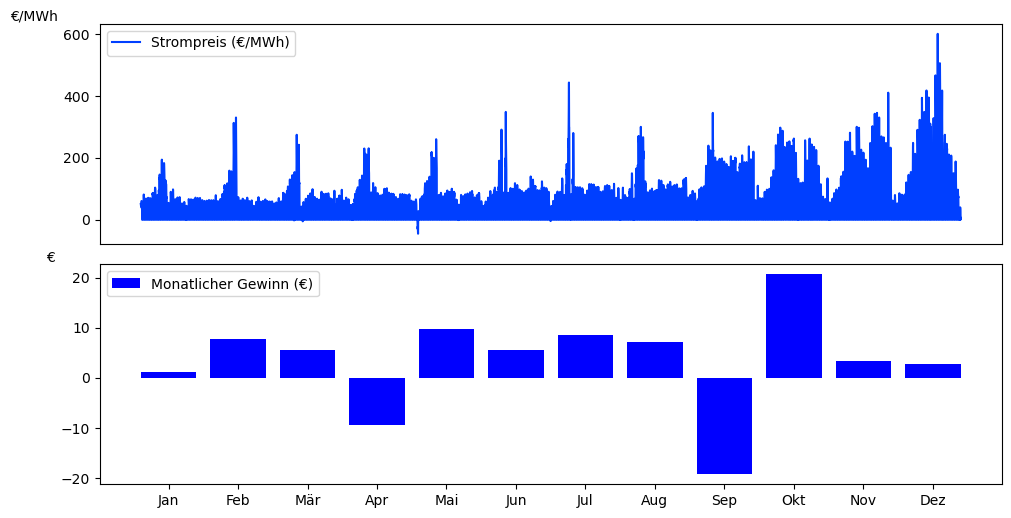

In [35]:
fig,ax=plt.subplots(2,1,figsize=(10,5), constrained_layout=True)
#ax.set_ylabel(labels, rotation=45)

monate=['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
y1=data_final['Profit ($)'].resample('M').sum().tolist()
#y2=monthly_discharging['Power output (kW)'].tolist()
y3=data21['price'].resample('H').sum()


#ax[1].bar(monate,y2,color="blue")
#ax[1].legend(["Monatliche Einspeisung (kW)"], loc='upper left')
ax[0].plot(data21['price'].resample('H').sum())
ax[0].legend(["Strompreis (€/MWh)"])
ax[0].set_ylabel("€/MWh", loc='top', rotation=0)
ax[0].xaxis.set_visible(False)
ax[1].bar(monate,y1,color="blue")
ax[1].legend(["Monatlicher Gewinn (€)"], loc='upper left')
ax[1].set_ylabel("€", loc='top', rotation=0)

#plt.savefig('Customed Plot.png', dpi=500, bbox_inches='tight')

In [36]:
monthly_profit = data_final['Profit ($)'].resample('M').sum().tolist()
monthly_discharging = (data_final_discharging['price'].resample('M').mean() /1000).tolist() #/ 1000
monthly_charging = (data_final_charging['price'].resample('M').mean() / 1000).tolist()
monthly_average = (data21['price'].resample('M').mean() / 1000).tolist()
monthly_output = (data_final_discharging['Power output (kW)'].resample('M').sum()).tolist()
monthly_data = pd.DataFrame([monthly_average, monthly_discharging, monthly_charging, monthly_profit, monthly_output])
monthly_data = monthly_data.T
monthly_data.columns = ['Preis', 'Entladen', 'Laden', 'Profit', 'Einspeisung']
monthly_data['Monat'] = monate
monthly_data['Spread'] = round(monthly_data['Entladen'] - monthly_data['Laden'], 4)
monthly_data['Marge'] = round(monthly_data['Spread'] / monthly_data['Entladen'] * 100, 2)
monthly_data = monthly_data[['Monat', 'Preis','Entladen', 'Laden', 'Spread', 'Marge', 'Profit', 'Einspeisung']]
monthly_data['Profit'] = round(monthly_data['Profit'], 2)
monthly_data['Preis'] = round(monthly_data['Preis'], 4)
monthly_data['Entladen'] = round(monthly_data['Entladen'], 4)
monthly_data['Laden'] = round(monthly_data['Laden'], 4)
monthly_data = monthly_data.set_index("Monat")
monthly_data

,Preis,Entladen,Laden,Spread,Marge,Profit,Einspeisung
Monat,,,,,,,
Jan,0.0578,0.0739,0.0502,0.0237,32.07,1.09,1292.0
Feb,0.0629,0.0796,0.0517,0.0279,35.07,7.69,1174.0
Mär,0.0626,0.0754,0.0530,0.0224,29.73,5.51,1360.0
Apr,0.0748,0.0869,0.0662,0.0206,23.72,-9.47,1144.0
Mai,0.0686,0.0859,0.0551,0.0308,35.86,9.69,1326.0
Jun,0.0835,0.0980,0.0687,0.0293,29.89,5.61,1336.0
Jul,0.0855,0.0964,0.0718,0.0246,25.53,8.59,1336.0
Aug,0.0896,0.0905,0.0693,0.0212,23.42,7.09,1176.0
Sep,0.1194,0.0918,0.0680,0.0238,25.92,-19.27,294.0


### Batterienutzung

In [37]:
#total charging power
data_final_charging['Power output (kW)'].sum() * -1

16548.0

In [38]:
#average charger capacity used when charging
data_final_charging['Power output (kW)'].mean() * -1

17.38235294117647

In [39]:
#total discharging power output
data_final_discharging['Power output (kW)'].sum()

12142.0

In [40]:
#average charger capacity used when discharging
data_final_discharging['Power output (kW)'].mean()

16.474898236092265

In [41]:
data_final_neutral_indexed = data_final_neutral.reset_index()
data_final_neutral_indexed['time'] = pd.to_datetime(data_final_neutral_indexed['Time Stamp']).dt.time
data_final_neutral_indexed['time'].value_counts()

00:00:00    323
13:00:00    321
12:00:00    320
11:00:00    308
01:00:00    301
06:00:00    284
05:00:00    274
10:00:00    228
09:00:00    216
07:00:00    212
02:00:00    196
04:00:00    150
08:00:00    150
03:00:00    138
Name: time, dtype: int64

In [42]:
data_final_charging_indexed = data_final_charging.reset_index()
data_final_charging_indexed['time'] = pd.to_datetime(data_final_charging_indexed['Time Stamp']).dt.time
data_final_charging_indexed['time'].value_counts()

03:00:00    223
04:00:00    211
02:00:00    159
07:00:00    152
05:00:00     75
01:00:00     54
06:00:00     43
00:00:00     25
11:00:00      4
09:00:00      3
13:00:00      2
10:00:00      1
Name: time, dtype: int64

In [43]:
data_final_discharging_indexed = data_final_discharging.reset_index()
data_final_discharging_indexed['time'] = pd.to_datetime(data_final_discharging_indexed['Time Stamp']).dt.time
data_final_discharging_indexed['time'].value_counts()

08:00:00    215
09:00:00    146
10:00:00    136
11:00:00     53
12:00:00     45
13:00:00     42
06:00:00     38
00:00:00     17
05:00:00     16
01:00:00     10
02:00:00     10
03:00:00      4
04:00:00      4
07:00:00      1
Name: time, dtype: int64

   Uhrzeit  Entladen  Laden  Neutral
0    18:00       365      0        0
1    19:00       354      1       10
2    20:00       360      0        5
3    21:00       242      3      120
4    22:00       120      0      245
5    23:00         7      1      357
6    00:00         1    128      236
7    01:00         1    270       94
8    02:00         4    307       54
9    03:00         1    356        8
10   04:00         1    351       13
11   05:00         2    232      131
12   06:00        86     90      189
13   07:00         0    141      224


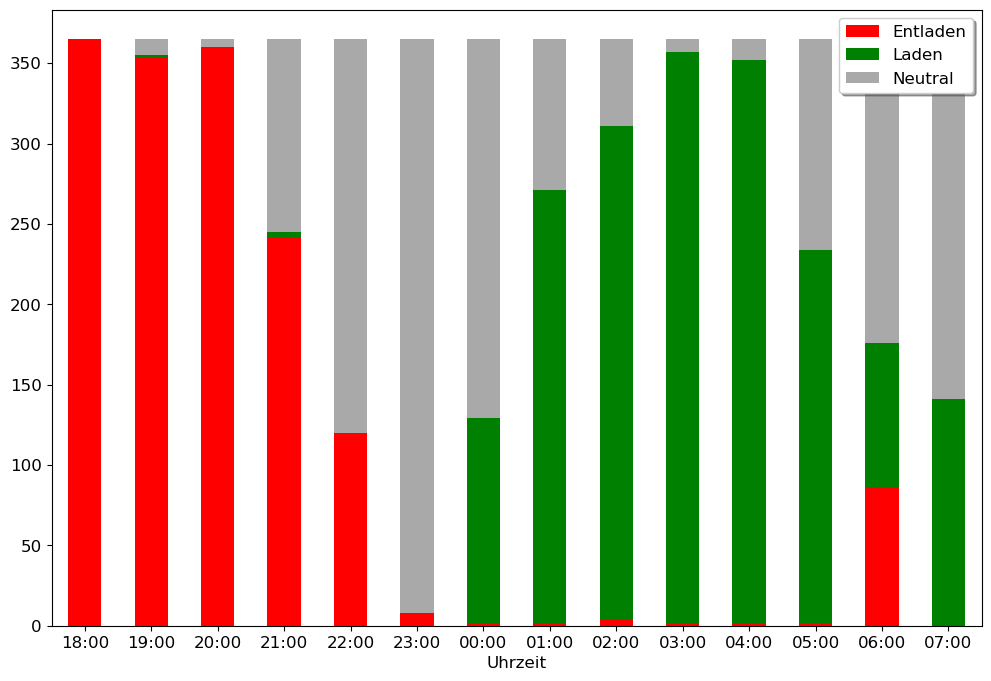

In [44]:
time_analysis = pd.DataFrame([["18:00", 365, 0, 0], ["19:00", 354, 1, 10], ["20:00", 360, 0, 5], ["21:00", 242, 3, 120],
                             ["22:00", 120, 0, 245], ["23:00", 7, 1, 357], ["00:00", 1, 128, 236], ["01:00", 1, 270, 94],
                             ["02:00", 4, 307, 54], ["03:00", 1, 356, 8], ["04:00", 1, 351, 13], ["05:00", 2, 232, 131],
                             ["06:00", 86, 90, 189], ["07:00", 0, 141, 224]],
                             columns=['Uhrzeit', 'Entladen', 'Laden', 'Neutral'])

print(time_analysis)

time_analysis.plot(x='Uhrzeit', kind='bar', stacked=True, figsize=(12,8), fontsize='large', rot=0,
                  color={"Entladen":"red", "Laden":"green", "Neutral":"darkgray"})
plt.xlabel("Uhrzeit", fontsize='large')
plt.legend(fontsize='large', loc='upper right', fancybox=True, shadow=True)

plt.savefig('Batterie nach Uhrzeit.png', dpi=1000, bbox_inches='tight')

In [45]:
monthly_discharging=data_final_discharging['Power output (kW)'].resample('M').sum().reset_index()
monthly_discharging

,Time Stamp,Power output (kW)
0,2021-01-31,1292.0
1,2021-02-28,1174.0
2,2021-03-31,1360.0
3,2021-04-30,1144.0
4,2021-05-31,1326.0
5,2021-06-30,1336.0
6,2021-07-31,1336.0
7,2021-08-31,1176.0
8,2021-09-30,294.0
9,2021-10-31,760.0


<Figure size 1600x1000 with 0 Axes>

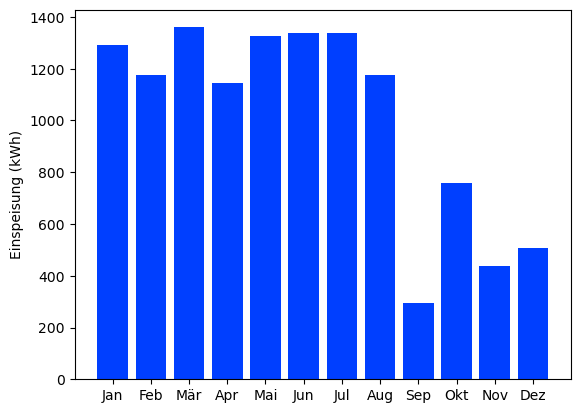

<Figure size 1600x1000 with 0 Axes>

In [46]:
xwerte=['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
ywerte=monthly_discharging['Power output (kW)'].tolist()
plt.bar(xwerte, ywerte)
plt.ylabel("Einspeisung (kWh)")
plt.figure(figsize=(16,10))
#plt.savefig('Einspeisung', dpi=1000, bbox_inches='tight')

In [47]:
data_morning = data_final.at_time('07:00')
data_morning[:50]

,price,Charging power (kW),Discharging power (kW),Power output (kW),State of Energy (kWh),Revenue generation ($),Charging cost ($),Profit ($)
Time Stamp,,,,,,,,
2021-01-01 07:00:00,40.09,22.0,0.0,-22.0,50.0,0.0,0.88198,-0.88198
2021-02-01 07:00:00,44.96,4.0,0.0,-4.0,60.0,0.0,0.17984,-0.17984
2021-03-01 07:00:00,32.63,0.0,0.0,0.0,60.0,0.0,0.00000,0.00000
2021-04-01 07:00:00,52.03,0.0,0.0,0.0,60.0,0.0,0.00000,0.00000
2021-05-01 07:00:00,54.96,22.0,0.0,-22.0,50.0,0.0,1.20912,-1.20912
2021-06-01 07:00:00,44.05,4.0,0.0,-4.0,60.0,0.0,0.17620,-0.17620
2021-07-01 07:00:00,67.80,22.0,0.0,-22.0,60.0,0.0,1.49160,-1.49160
2021-08-01 07:00:00,79.56,22.0,0.0,-22.0,60.0,0.0,1.75032,-1.75032
2021-09-01 07:00:00,53.82,0.0,0.0,0.0,50.0,0.0,0.00000,0.00000


Text(0.5, 1.0, '')

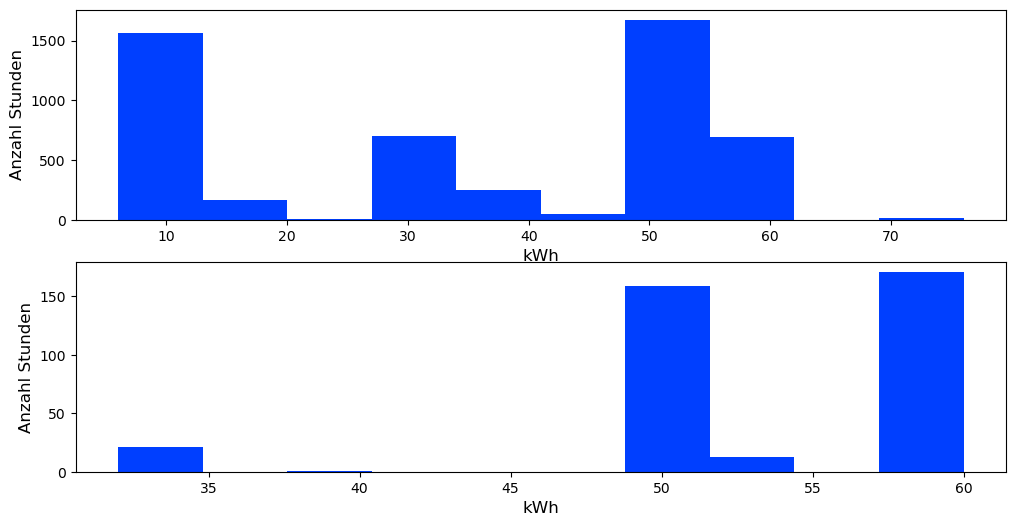

In [48]:
#Analyse final data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.hist(all_hourly_state_of_energy)
plt.xlabel("kWh", fontsize="large")
plt.ylabel("Anzahl Stunden", fontsize="large")
plt.title('')

plt.subplot(2, 1, 2)
plt.hist(data_morning["State of Energy (kWh)"])
plt.xlabel('kWh', fontsize="large")
plt.ylabel("Anzahl Stunden", fontsize="large")
plt.title('')
#plt.savefig('Akkuladestand 100 kWh.png', dpi=1000, bbox_inches='tight')

## Results sensitivity analysis

    Battery size  Profit
0             20  206.65
1             25  291.92
2             30  375.80
3             35  449.98
4             40  518.45
5             45  580.01
6             50  630.66
7             55  677.67
8             60  706.16
9             65  734.82
10            70  737.44
11            75  738.22
12            80  738.45
13            85  738.64
14            90  738.74
15            95  738.74
16           100  738.74
0.7202669410076618


Text(0, 0.5, 'Profit (€)')

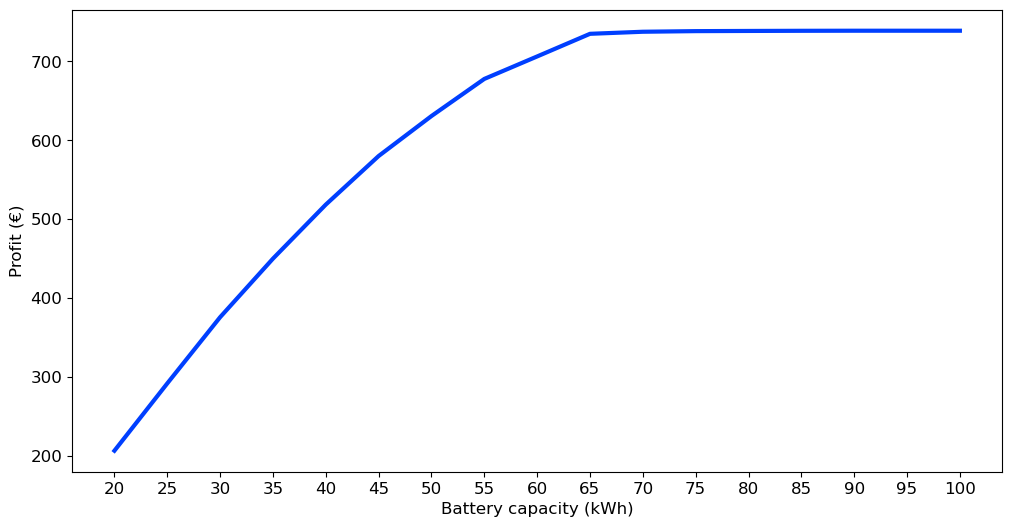

In [49]:


battery_analysis = pd.DataFrame([[20, 206.65], [25, 291.92], [30, 375.80], [35, 449.98], [40, 518.45], [45, 580.01], 
                                 [50, 630.66], [55, 677.67], [60, 706.16], [65, 734.82], [70, 737.44], [75, 738.22],
                                 [80, 738.45],[85, 738.64], [90, 738.74], [95, 738.74], [100, 738.74]],
                               columns=['Battery size', 'Profit'])

print(battery_analysis)

SI_battery = (battery_analysis['Profit'].max() - battery_analysis['Profit'].min()) / battery_analysis['Profit'].max()
print(SI_battery)

battery_analysis.plot(x='Battery size', xticks=(battery_analysis['Battery size']), kind='line', figsize=(12,6), 
                      fontsize='large', rot=0, legend=(), linewidth=3)
plt.xlabel("Battery capacity (kWh)", fontsize='large')
plt.ylabel("Profit (€)", fontsize='large')

#plt.savefig('Gewinn nach Batterie.png', dpi=1000, bbox_inches='tight')